In [1]:
import warnings
warnings.filterwarnings("ignore") # Suppress warnings, useful for cleaner output

import numpy as np
import pandas as pd

import xgboost as xgb
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split

import pmdarima as pm

In [2]:
# Simulate time series data (e.g., monthly sales)
np.random.seed(123)

time = np.arange(1, 101) # Simulate time values (e.g., 100 months)
seasonal_effect = 10 * np.sin(2 * np.pi * time / 12) # Generate seasonal effect (e.g., yearly seasonality)
trend_effect = 0.1 * time # Generate trend effect (e.g., linear trend over time)
noise = np.random.normal(0, 2, size=len(time)) # Add random noise to simulate real-world variability

# Combine all components to create the time series data
data = 50 + trend_effect + seasonal_effect + noise

# Create a DataFrame
df = pd.DataFrame({'time': time, 'value': data})

# df['time'] = pd.date_range(start='2000-01-01', periods=len(df), freq='M')

# Set the 'time' column as the index
df.set_index('time', inplace=True)


df.head()

,value
time,
1,52.928739
2,60.854945
3,60.865957
4,56.047665
5,54.342799


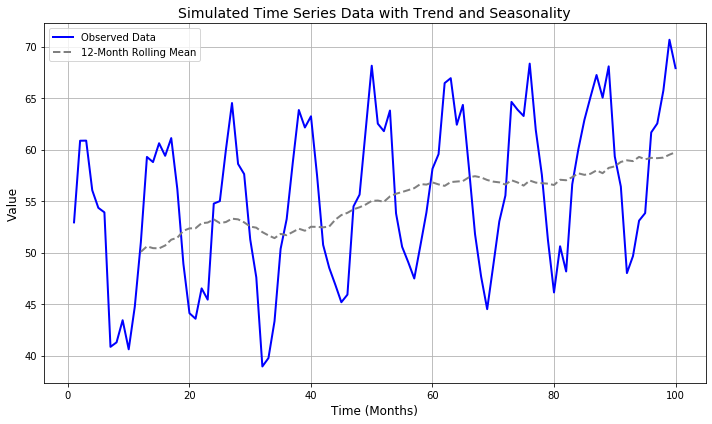

In [3]:
plt.figure(figsize=(10, 6))

# Plot the raw time series data
plt.plot(df.index, df['value'], label='Observed Data', color='blue', linewidth=2)

# Add a rolling average to highlight the trend
rolling_window = 12  # 12-month rolling average
df['rolling_mean'] = df['value'].rolling(window=rolling_window).mean()
plt.plot(df.index, df['rolling_mean'], label=f'{rolling_window}-Month Rolling Mean',
         color='gray', linestyle='--', linewidth=2)

plt.title('Simulated Time Series Data with Trend and Seasonality', fontsize=14)
plt.xlabel('Time (Months)', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [4]:
# Fit AutoARIMA model
auto_arima_model = pm.auto_arima(df['value'], seasonal=True, m=12, 
                                 stepwise=True, trace=True,
                                 suppress_warnings=True, 
                                 max_order=6)

# Print the summary of the fitted AutoARIMA model
print(auto_arima_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=1.43 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=594.076, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=552.874, Time=0.15 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=574.744, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=592.176, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=589.855, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.62 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=574.497, Time=0.14 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=1.98 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=566.511, Time=0.08 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=inf, Time=0.74 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=inf, Time=0.59 sec
 ARIMA(2,1,1)(1,0,0)[12] intercept   : AIC=inf, Time=0.94 sec

In [5]:
auto_arima_model

ARIMA(order=(0, 1, 1), scoring_args={}, seasonal_order=(1, 0, 2, 12),
      suppress_warnings=True, with_intercept=False)

D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


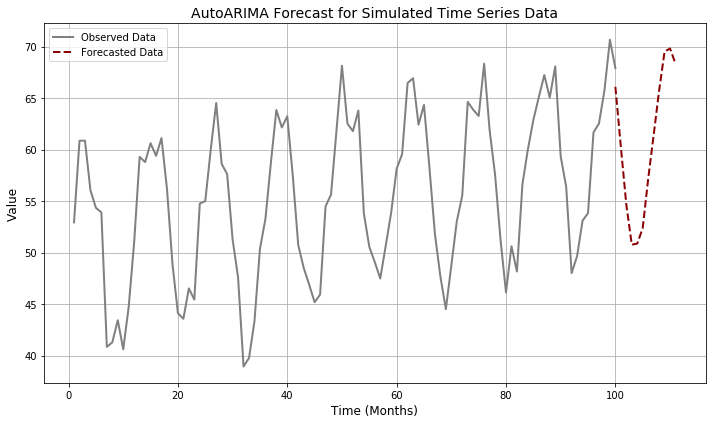

In [6]:
# Forecast using AutoARIMA

forecast_steps = 12  # Forecasting the next 12 time steps (e.g., 12 months)
forecast = auto_arima_model.predict(n_periods=forecast_steps)

# Visualize the original series and the forecast
plt.figure(figsize=(10, 6))
# Plot the original time series data
plt.plot(df.index, df['value'], label='Observed Data', color='gray', linewidth=2)
# Plot the forecasted values
forecast_index = np.arange(len(df), len(df) + forecast_steps)
plt.plot(forecast_index, forecast, label='Forecasted Data', color='darkred', linestyle='--', linewidth=2)
plt.title('AutoARIMA Forecast for Simulated Time Series Data', fontsize=14)
plt.xlabel('Time (Months)', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Weighted Average Method (SARIMAX-XGBoost)
Steps:

Fit the SARIMA model on the time series data.
Fit the XGBoost model on the residuals of the SARIMA model.
Forecast the future values using both models.
Combine the forecasts using a weighted average.

D:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


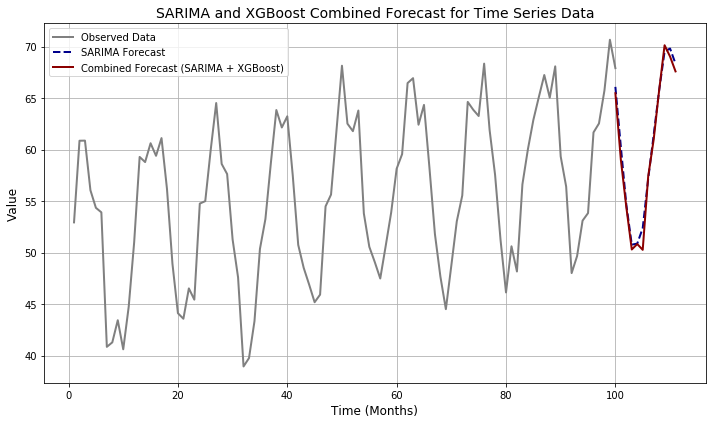

In [9]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

# Compute residuals from SARIMA model
sarima_residuals = df['value'] - auto_arima_model.predict_in_sample()

# Prepare residuals for XGBoost
# Feature engineering: include lags of residuals or other time series features
lags = 12  

residuals_lagged = pd.DataFrame({
    'residual': sarima_residuals,
    'lag1': sarima_residuals.shift(1),
    'lag2': sarima_residuals.shift(2),
    'lag3': sarima_residuals.shift(3),
    'lag4': sarima_residuals.shift(4),
    'lag5': sarima_residuals.shift(5),
    'lag6': sarima_residuals.shift(6),
    'lag7': sarima_residuals.shift(7),
    'lag8': sarima_residuals.shift(8),
    'lag9': sarima_residuals.shift(9),
    'lag10': sarima_residuals.shift(10),
    'lag11': sarima_residuals.shift(11),
})

# Drop missing values due to shifting
residuals_lagged = residuals_lagged.dropna()

# Train an XGBoost model on the residuals
X = residuals_lagged.drop(columns=['residual'])
y = residuals_lagged['residual']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Initialize and fit the XGBoost model
xgb_model = xgb.XGBRegressor(
    n_estimators=100,              # Number of boosting rounds
    learning_rate=0.1,             # Step size
    max_depth=6,                   # Maximum depth of a tree
    subsample=0.8,                 # Fraction of samples used for fitting each tree
    colsample_bytree=0.8,          # Fraction of features used for each tree
    gamma=0,                       # Regularization term (controls overfitting)
    n_jobs=-1,                     # Parallel computation
    random_state=123               # For reproducibility
)
xgb_model.fit(X_train, y_train)

# Forecast the future residuals using XGBoost
future_lags = pd.DataFrame({
    'lag1': sarima_residuals[-lags:].values,
    'lag2': sarima_residuals[-lags-1:-1].values,
    'lag3': sarima_residuals[-lags-2:-2].values,
    'lag4': sarima_residuals[-lags-3:-3].values,
    'lag5': sarima_residuals[-lags-4:-4].values,
    'lag6': sarima_residuals[-lags-5:-5].values,
    'lag7': sarima_residuals[-lags-6:-6].values,
    'lag8': sarima_residuals[-lags-7:-7].values,
    'lag9': sarima_residuals[-lags-8:-8].values,
    'lag10': sarima_residuals[-lags-9:-9].values,
    'lag11': sarima_residuals[-lags-10:-10].values,
})

# Forecast residuals
forecasted_residuals = xgb_model.predict(future_lags)

# Forecast the future values using SARIMA (baseline) and XGBoost (residuals)
# Get SARIMA's forecasted values
sarima_forecast = auto_arima_model.predict(n_periods=forecast_steps)

# Combine the forecasts using a weighted average 
# combined_forecast = sarima_forecast + forecasted_residuals
weight_sarima = 1
weight_xgboost = +0.8
combined_forecast = weight_sarima * sarima_forecast + weight_xgboost * forecasted_residuals


# Visualize the results
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['value'], label='Observed Data', color='gray', linewidth=2)
forecast_index = np.arange(len(df), len(df) + forecast_steps)
plt.plot(forecast_index, sarima_forecast, label='SARIMA Forecast', color='darkblue', linestyle='--', linewidth=2)
plt.plot(forecast_index, combined_forecast, label='Combined Forecast (SARIMA + XGBoost)', color='darkred', linestyle='-', linewidth=2)
plt.title('SARIMA and XGBoost Combined Forecast for Time Series Data', fontsize=14)
plt.xlabel('Time (Months)', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
